<a href="https://colab.research.google.com/github/Priyansh012/CECS550-Facial-Expression-Recognition/blob/main/Facial_Expression_Recognition_Using_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'facial-expression-recognitionferchallenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F64677%2F127160%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T231403Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ee85c1087a283ec3120edf2c093826c84e377223650d52a72c44e54f376e2763d5a5b26c9b948c858f71622e6ab7cad576d44c9cdf19610f3b974a9e2a310169b63856c84c87353cf24e0a4d62ed468732bdba1f1b28aa8842eee91b5240c6e3bab5c1a624fb11a81b15d1e3857f69f11f7b5698c86ae53e828beaa15d0875e96efc724383857147129685374a2879c1b27c161a4a6ff322e724dd4eeef81aa8f42314ce8bf2a361dfcec155d2e51d086a3bd4f875616b65f3006589671f9f1f2ea75879c18152fd8e5d2419567189d01f27fc76d17340d98df1bf6d749ec64e5d28a63009fe34046c87effb3ac06ce264c009e295c302e17ea11f8c3b98908'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 101283289 bytes downloaded
Downloaded and uncompressed: facial-expression-recognitionferchallenge
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for directory, subdirectories, files in os.walk('/kaggle/input'):
    for file in files:
        print(os.path.join(directory, file))


/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib


In [ ]:
import cv2
!pip install scikit-plot
import scikitplot
import seaborn as sns
from matplotlib import pyplot
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D,MaxPool2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [ ]:
import pandas as pd

# Reading CSV into dataframe.
new_d = pd.read_csv("/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv")

# 5 rows of dataset.
new_d.head(5)

# Assigning shape
new_d_shape = new_d.shape

# Printing dataframe shape
print(new_d_shape)


(35887, 3)


In [ ]:
new_d['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [ ]:
new_d['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
len(new_d['pixels'][0])
math.sqrt(len(new_d.pixels[35886].split(' ')))

48.0

In [ ]:
emotion_label={0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

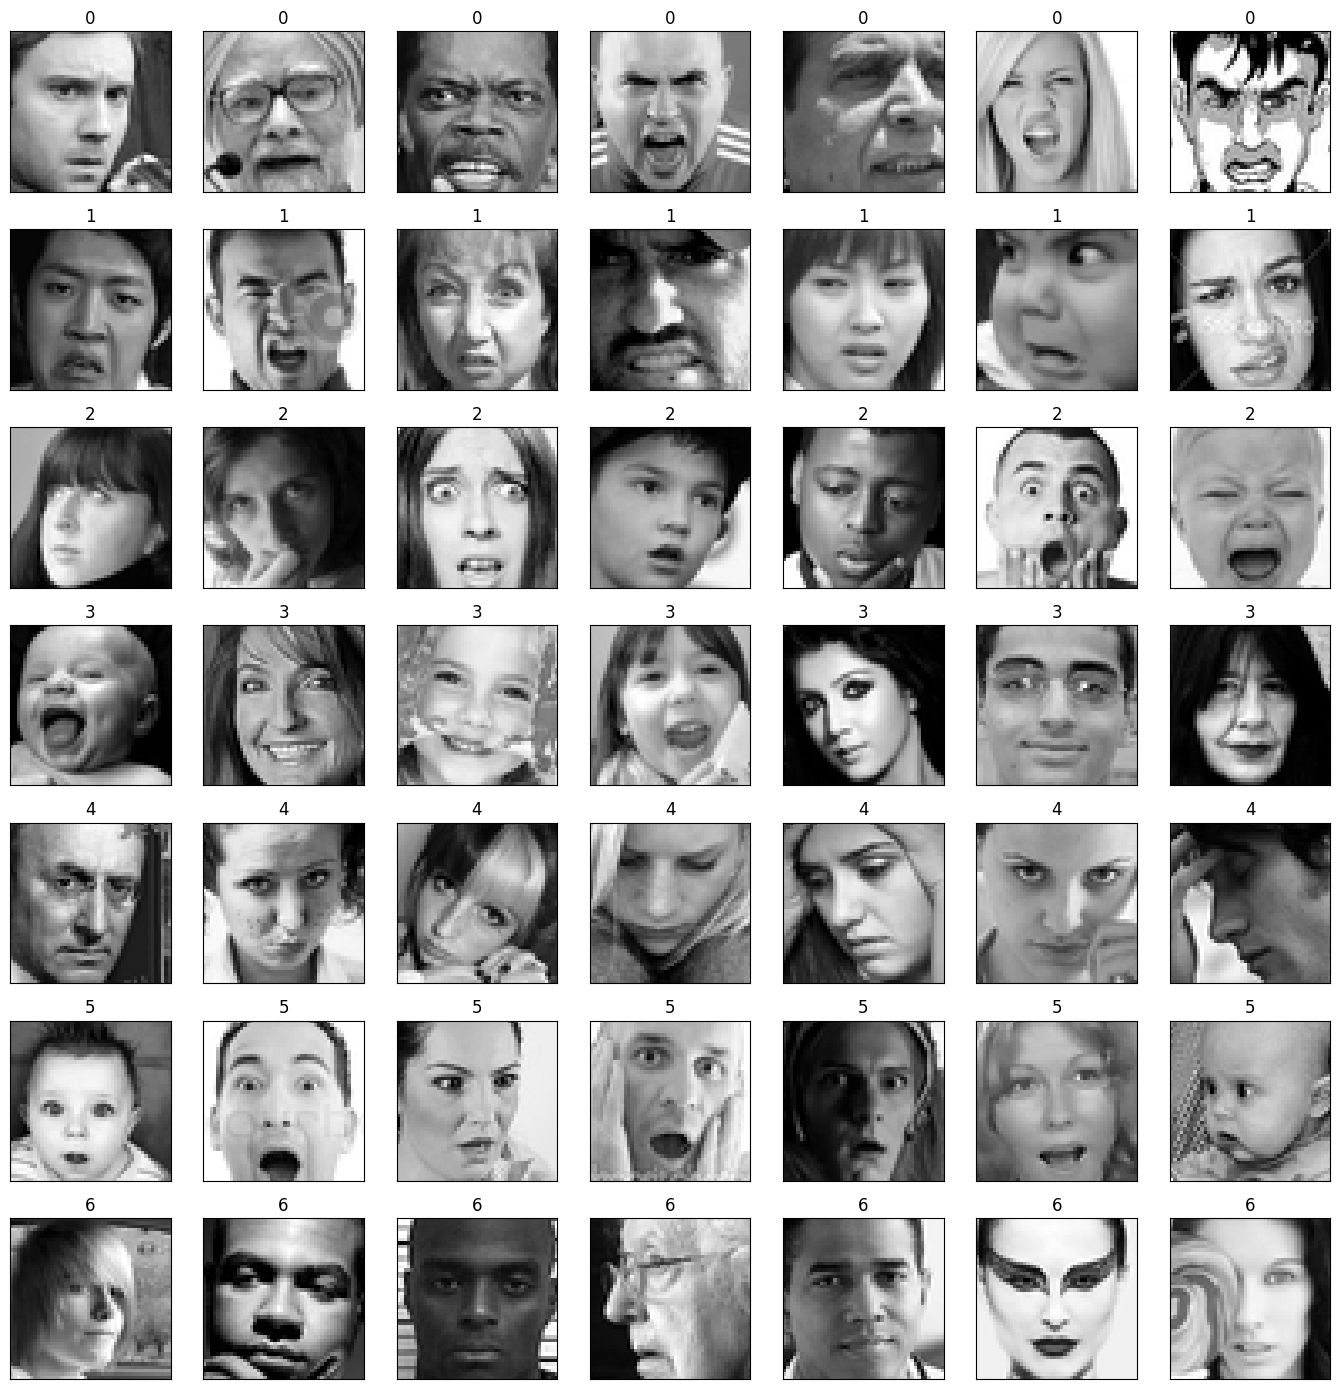

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with specified size
fig = plt.figure(1, (14, 14))

# Initialize index for iterating through emotion labels
idx = 0

# Iterate over unique emotion labels in the dataframe
for emotion_label in sorted(new_d['emotion'].unique()):
    # Iterate over each image for the current emotion label
    for j in range(7):
        # Extract pixel data for the current image
        pixels_data = new_d[new_d['emotion']==emotion_label]['pixels'].iloc[idx]
        pixels_data = np.array(pixels_data.split(' ')).reshape(48, 48).astype('float32')

        # Increment index for next image
        idx += 1

        # Create subplot for the current image
        subplot = plt.subplot(7, 7, idx)

        # Display the image with grayscale colormap
        subplot.imshow(pixels_data, cmap='gray')

        # Remove x and y ticks
        subplot.set_xticks([])
        subplot.set_yticks([])

        # Set title for the subplot with the emotion label
        subplot.set_title(emotion_label)

        # Adjust layout to prevent overlapping
        plt.tight_layout()


In [ ]:
import numpy as np

image_array = new_d['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
print(image_array)


0        [[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...
1        [[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 11...
2        [[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 16...
3        [[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...
4        [[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                               ...                        
35882    [[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39...
35883    [[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 19...
35884    [[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17...
35885    [[30.0, 28.0, 28.0, 29.0, 31.0, 30.0, 42.0, 68...
35886    [[19.0, 13.0, 14.0, 12.0, 13.0, 16.0, 21.0, 33...
Name: pixels, Length: 35887, dtype: object


In [ ]:
import numpy as np

image_data = np.stack(image_array, axis=0)
print(image_data.shape)
print(image_data[0])


(35887, 48, 48)
[[ 70.  80.  82. ...  52.  43.  41.]
 [ 65.  61.  58. ...  56.  52.  44.]
 [ 50.  43.  54. ...  49.  56.  47.]
 ...
 [ 91.  65.  42. ...  72.  56.  43.]
 [ 77.  82.  79. ... 105.  70.  46.]
 [ 77.  72.  84. ... 106. 109.  82.]]


In [ ]:
import cv2
import numpy as np

image_features = []
for i in range(len(image_data)):
    temp = cv2.cvtColor(image_data[i], cv2.COLOR_GRAY2RGB)
    image_features.append(temp)

image_features = np.array(image_features)
print(image_features.shape)


(35887, 48, 48, 3)


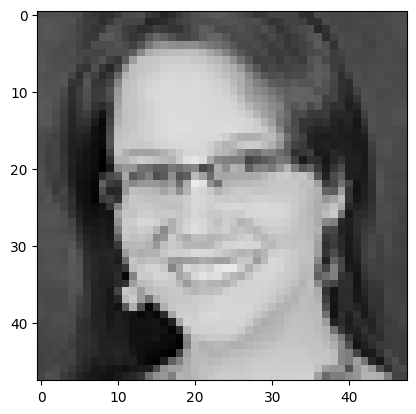

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image_features[7].astype(np.uint8))
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
image_labels = label_encoder.fit_transform(new_d['emotion'])
image_labels = to_categorical(image_labels)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(image_features, image_labels, stratify=image_labels, test_size=0.1, random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(32298, 48, 48, 3) (3589, 48, 48, 3) (32298, 7) (3589, 7)


In [ ]:
from re import X
x_train = x_train / 255.
x_test = x_test / 255.

In [ ]:
img_width = 48
img_height = 48
channels = 3


In [ ]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',include_top = False,input_shape = (img_width, img_height, channels))

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def get_model(built_model, num_classes):
    model_output = built_model.layers[-2].output
    model_output = GlobalAveragePooling2D()(model_output)
    model_output = Dense(num_classes, activation='softmax', name='output_layer')(model_output)

    return model_output


In [ ]:
num_categories = 7
head_output = get_model(vgg, num_categories)

model = Model(inputs=vgg.input, outputs=head_output)

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.00005, patience=11, verbose=1, restore_best_weights=True)
lr_scheduler_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=1e-7, verbose=1)
callbacks_list = [early_stopping_callback, lr_scheduler_callback]


In [ ]:
train_data_generator = ImageDataGenerator(rotation_range=15,
                                          width_shift_range=0.15,
                                          height_shift_range=0.15,
                                          shear_range=0.15,
                                          zoom_range=0.15,
                                          horizontal_flip=True)
train_data_generator.fit(x_train)

batch_size = 256
epochs = 30

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data_generator.flow(x_train,
                                              y_train,
                                              batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    steps_per_epoch=len(x_train) / batch_size,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    use_multiprocessing=True)


Epoch 1/30


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


124/126 [============================>.] - ETA: 1s - loss: 1.6092 - accuracy: 0.3582

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


126/126 [==============================] - 84s 514ms/step - loss: 1.6033 - accuracy: 0.3609 - val_loss: 1.3001 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 2/30
126/126 [==============================] - 67s 528ms/step - loss: 1.2873 - accuracy: 0.5078 - val_loss: 1.1627 - val_accuracy: 0.5606 - lr: 1.0000e-04
Epoch 3/30
126/126 [==============================] - 65s 515ms/step - loss: 1.1746 - accuracy: 0.5527 - val_loss: 1.1058 - val_accuracy: 0.5731 - lr: 1.0000e-04
Epoch 4/30
126/126 [==============================] - 66s 521ms/step - loss: 1.1127 - accuracy: 0.5761 - val_loss: 1.0535 - val_accuracy: 0.6016 - lr: 1.0000e-04
Epoch 5/30
126/126 [==============================] - 66s 518ms/step - loss: 1.0595 - accuracy: 0.6006 - val_loss: 1.0280 - val_accuracy: 0.6121 - lr: 1.0000e-04
Epoch 6/30
126/126 [==============================] - 64s 500ms/step - loss: 1.0321 - accuracy: 0.6085 - val_loss: 1.0052 - val_accuracy: 0.6188 - lr: 1.0000e-04
Epoch 7/30
126/126 [===================

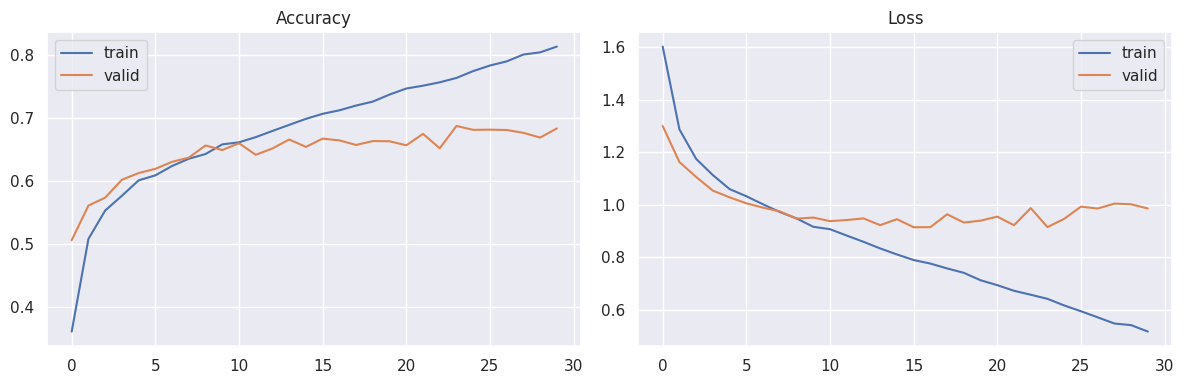

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()


113/113 [==============================] - 2s 14ms/step


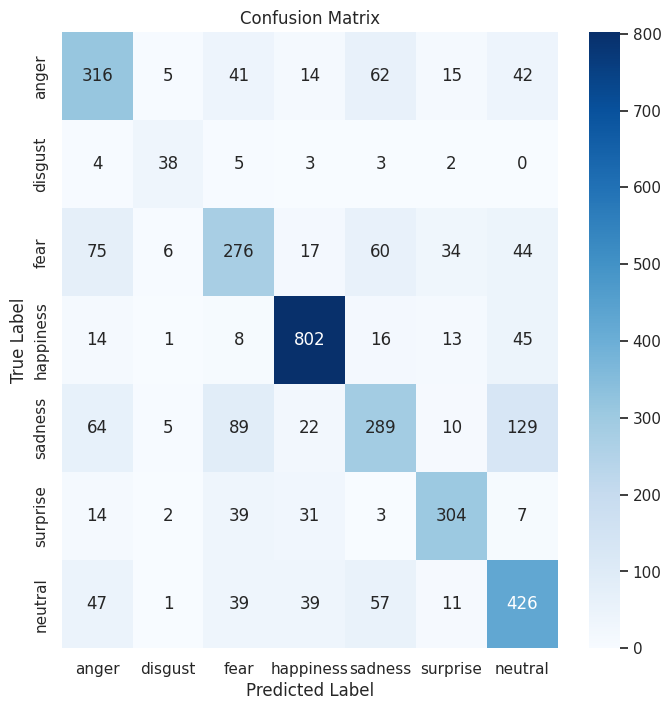

In [ ]:
from sklearn.metrics import confusion_matrix

# Get the predictions for the test set
y_pred = model.predict(x_test)
# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
fig = pyplot.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_label.values(), yticklabels=emotion_label.values())
pyplot.title("Confusion Matrix")
pyplot.xlabel("Predicted Label")
pyplot.ylabel("True Label")
pyplot.show()